In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from arch.univariate import ConstantMean, GARCH, StudentsT, Normal
import matplotlib.pyplot as plt
import warnings
from collections import deque


warnings.filterwarnings("ignore")  # nuke all warnings



In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')['market_forward_excess_returns']


In [3]:
X_features = X_train[-500:]
X_train = X_train[:-500]
y_features = y_train[-500:]
y_train = y_train[:-500]

In [4]:
def feature_selection(X_tr, y_tr, X_va, y_va, *, k=30, top_corr=60,
                     use_extratrees=True, val_last=252, n_repeats=5, seed=42, w_corr=0.6, w_perm=0.4):
    # 1) keep a small validation slice
    if val_last is not None and len(X_va) > val_last:
        Xv = X_va.iloc[-val_last:].astype(np.float32).copy()
        yv = y_va.iloc[-val_last:].to_numpy()
    else:
        Xv = X_va.astype(np.float32).copy()
        yv = y_va.to_numpy()

    # 2) univariate Pearson on TRAIN; take top N
    corr_abs = X_tr.apply(lambda c: np.corrcoef(c, y_tr)[0,1], axis=0).abs().fillna(0.0)
    cand = corr_abs.sort_values(ascending=False).head(min(top_corr, X_tr.shape[1])).index.tolist()

    # 3) small, fast tree on TRAIN
    Tree = ExtraTreesRegressor if use_extratrees else RandomForestRegressor
    tree = Tree(
        n_estimators=100, max_depth=8, min_samples_leaf=0.01, max_features=0.7,
        n_jobs=-1, random_state=seed
    ).fit(X_tr[cand].astype(np.float32), y_tr.to_numpy())

    # 4) permutation importance on VALID (few repeats, parallel)
    pi = permutation_importance(tree, Xv[cand], yv, n_repeats=n_repeats,
                                random_state=seed, scoring="neg_mean_squared_error", n_jobs=-1)
    perm = pd.Series(pi.importances_mean, index=cand)

    # 5) combine by rank (robust to scaling)
    r_corr = corr_abs.loc[cand].rank(ascending=False)
    r_perm = perm.rank(ascending=False)
    score = (w_corr * r_corr + w_perm * r_perm).sort_values(ascending=False)

    selected = score.index[:min(k, len(score))].tolist()
    summary = pd.DataFrame({"corr_abs": corr_abs.loc[cand], "perm": perm, "score_rank": score}).loc[score.index]
    return selected, summary

In [5]:
def logistic_train(X_train, y_train, features = None, C=1.0):
    """
    Train a Logistic regression model and evaluate on validation set.

    Parameters
    ----------
    X_train : pd.DataFrame
        Training features.
    y_train : pd.Series
        Training target.
   
    C : float, default 1.0
        Inverse of regularization strength for Logistic regression.

    Returns
    -------
    model : LogisticRegression
        Trained Logistic regression model.
    
    """
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(penalty = "l2", solver = 'lbfgs', C=C, max_iter=2000))
    ])

    if features:
        model.fit(X_train[features], y_train)
    else:
        model.fit(X_train, y_train)

    return model

In [6]:
def trees_train(X_train, y_train, features = None, type='RandomForest'):
    """
    Train a Tree Regressor and evaluate on validation set.

    Parameters
    ----------
    X_train : pd.DataFrame
        Training features.
    y_train : pd.Series
        Training target.
   
    n_estimators : int, default 100
        Number of trees in the forest.
    
    max_depth : int or None, default None
        Maximum depth of the tree.

    random_state : int, default 42
        Random seed for reproducibility.

    Returns
    -------
    model : Regressor
    
    """
    
    if type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=1000,
            max_depth=6,
            min_samples_leaf=0.03,     # 3% of samples per leaf (robust)
            min_samples_split=0.02,
            max_features=0.3,
            bootstrap=True,
            n_jobs=-1, random_state=42)
        
    elif type == 'ExtraTrees':
        model = ExtraTreesRegressor(
            n_estimators=600,
            max_depth=8,
            min_samples_leaf=0.01,
            min_samples_split=0.02,
            max_features=0.7,
            bootstrap=False,
            n_jobs=-1, random_state=42
        )

    elif type == 'XGBoost':
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.10,
            max_depth=4,
            subsample=0.7,
            colsample_bytree=0.7,
            min_child_weight=10,       # combats noise
            reg_lambda=2.0,
            objective="reg:squarederror",
            n_jobs=-1, random_state=42
        )
    elif type == 'LightGBM':
        model = LGBMRegressor(
            verbosity = -1,
            n_estimators=800,
            learning_rate=0.01,
            max_depth=6,
            num_leaves=31,             # <= 2^max_depth for safety
            min_data_in_leaf=150,      # robust on small-signal data
            feature_fraction=0.9,
            bagging_fraction=0.7,
            bagging_freq=1,
            lambda_l2=20.0,
            extra_trees=True,          # adds randomness like ExtraTrees
            n_jobs=-1, random_state=42,
            min_gain_to_split=1e-3
        )
    if features:
        model.fit(X_train[features], y_train)
    else:
        model.fit(X_train, y_train)

    return model

In [7]:
def linear_calibrate(pred_train, y_train, *, dropna: bool = True, fit_intercept: bool = True):
    """
    Fit a scikit-learn LinearRegression on TRAIN predictions:
        y = alpha + beta * pred

    Returns a Pipeline that reshapes 1D inputs and applies the fitted LinearRegression.
    You can call .predict(...) on it with a 1D array/list/Series of predictions.

    Parameters
    ----------
    pred_train : array-like, shape (n_samples,)
        Model predictions on the training window (e.g., your tree's outputs).
    y_train : array-like, shape (n_samples,)
        Realized targets on the training window (e.g., next-day returns).
    dropna : bool, default True
        Drop pairs with NaN/Inf before fitting. If False and NaNs exist, raises ValueError.
    fit_intercept : bool, default True
        Passed to LinearRegression.

    Returns
    -------
    model : sklearn Pipeline
        Use model.predict(new_pred) to get calibrated predictions.
        Access alpha/beta via:
            alpha = model.named_steps['lr'].intercept_
            beta  = model.named_steps['lr'].coef_[0]
    """
    x = np.asarray(pred_train, dtype=float).flatten()
    y = np.asarray(y_train, dtype=float).flatten()
    if x.shape != y.shape:
        raise ValueError("pred_train and y_train must have the same shape")

    mask = np.isfinite(x) & np.isfinite(y)
    if not dropna and not mask.all():
        raise ValueError("NaNs/Infs present; set dropna=True to filter them out.")
    x, y = x[mask], y[mask]
    if x.size < 2:
        raise ValueError("Not enough data to calibrate (need ≥2 finite pairs).")

    # Pipeline so you can pass 1D arrays to .predict() without manual reshape
    model = Pipeline(steps=[
        ("reshape", FunctionTransformer(lambda z: np.asarray(z, dtype=float).reshape(-1, 1), validate=False)),
        ("lr", LinearRegression(fit_intercept=fit_intercept)),
    ])
    model.fit(x, y)
    return model


In [8]:
def mean_predict(model, X, calibrate_model):
    """
    Generate predictions using the trained model.

    Parameters
    ----------
    model : Trained model
        The trained regression model.
    X : pd.DataFrame
        Features for prediction.

    Returns
    -------
    y_pred : np.ndarray
        Predicted values.
    """
    y_pred = model.predict(X)

    calibrated_pred = calibrate_model.predict(y_pred)
    return calibrated_pred

In [9]:
def make_lag_features(df, cols, lags=(1, 5, 20), *, keep_original=True, dtype="float32"):
    """
    Returns a new DataFrame with optional originals + lagged copies.
    Uses shift(L), so expect NaNs at the head.
    """
    out = pd.DataFrame(index=df.index)
    if keep_original:
        out[cols] = df[cols]
    for L in lags:
        out[[f"{c}_lag{L}" for c in cols]] = df[cols].shift(L)
    if dtype is not None:
        for c in out.columns:
            if pd.api.types.is_float_dtype(out[c]):
                out[c] = out[c].astype(dtype)
    return out

In [10]:
# 4) Rolling stats (+ optional z-scores), time-safe via past_only=True
def make_rolling_features(
    df, cols,
    windows=(5, 20),
    *,
    stats=("mean", "std"),     # any of: "mean","std","min","max","sum"
    zscore: bool = False,       # z_t = (x_t - mean_{past}) / (std_{past}+eps)
    past_only: bool = True,    # shift(1) inside rolling to avoid leakage
    min_periods: int = None,  # default = window size
    eps: float = 1e-9,
    dtype: str = "float32",
):
    """
    Builds rolling features for each col over each window.
    If past_only=True, the rolling window excludes the current row (safe for t+1 targets).
    """
    out = pd.DataFrame(index=df.index)
    for w in windows:
        mp = w if min_periods is None else min_periods
        base = df[cols].shift(1) if past_only else df[cols]
        roll = base.rolling(window=w, min_periods=mp)

        if "mean" in stats:
            m = roll.mean()
            out[[f"{c}_rollmean{w}" for c in cols]] = m
        if "std" in stats:
            s = roll.std(ddof=0)
            out[[f"{c}_rollstd{w}" for c in cols]] = s
        if "min" in stats:
            out[[f"{c}_rollmin{w}" for c in cols]] = roll.min()
        if "max" in stats:
            out[[f"{c}_rollmax{w}" for c in cols]] = roll.max()
        if "sum" in stats:
            out[[f"{c}_rollsum{w}" for c in cols]] = roll.sum()

        if zscore:
            # need mean & std; compute if not already available
            if "mean" in stats:
                m = out[[f"{c}_rollmean{w}" for c in cols]].copy()
                m.columns = cols
            else:
                m = roll.mean()
            if "std" in stats:
                s = out[[f"{c}_rollstd{w}" for c in cols]].copy()
                s.columns = cols
            else:
                s = roll.std(ddof=0)
            for c in cols:
                out[f"{c}_z{w}"] = (df[c] - m[c]) / (s[c] + eps)

    if dtype is not None:
        for c in out.columns:
            if pd.api.types.is_float_dtype(out[c]):
                out[c] = out[c].astype(dtype)
    return out

In [11]:
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')['market_forward_excess_returns']

In [12]:
X_val

,D1_rollmean5,D2_rollmean5,D3_rollmean5,D4_rollmean5,D5_rollmean5,D6_rollmean5,D7_rollmean5,D8_rollmean5,D9_rollmean5,E1_rollmean5,...,V13_z60,V2_z60,V3_z60,V4_z60,V5_z60,V6_z60,V7_z60,V8_z60,lagged_market_forward_excess_returns_z60,lagged_risk_free_rate_z60
0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.663594,...,-0.718964,0.760948,0.593287,0.713412,-0.513155,-0.264339,-0.968858,1.080518,0.736308,0.454674
1,0.0,0.0,0.0,0.0,0.0,-0.8,0.0,0.2,0.0,0.662568,...,-0.919517,0.718234,0.666469,0.669194,-1.513536,-0.206116,-1.204478,1.045414,0.127694,0.308413
2,0.0,0.0,0.0,0.0,0.2,-0.6,0.0,0.4,0.0,0.661542,...,-0.923600,0.707579,0.525649,0.542739,-0.813849,-0.085268,-1.215674,1.076759,0.645975,0.089529
3,0.0,0.0,0.0,0.0,0.4,-0.4,0.0,0.6,0.0,0.660517,...,-0.964446,0.649531,0.651329,0.530414,0.164854,-0.823583,-1.245541,1.012096,0.812391,0.034375
4,0.0,0.0,0.0,0.0,0.6,-0.2,0.0,0.6,0.2,0.659492,...,-0.913449,0.670378,0.646824,0.609735,0.189576,-0.807311,-1.181134,1.040495,0.316569,-0.356735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.2,0.0,0.2,0.0,0.2,0.0,0.4,1.608314,...,2.624379,1.634162,0.698517,2.010182,-1.427859,0.247978,2.290047,1.892456,-1.486409,-0.559135
996,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,1.605683,...,1.226190,1.511876,0.283117,1.926646,-1.162139,0.416981,1.202319,1.785066,0.263555,-0.669419
997,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.603060,...,1.194332,1.389627,-0.074592,1.844818,-1.641298,0.280935,1.228596,1.651045,-1.063217,-0.730449
998,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.600445,...,0.302263,1.258981,-0.458043,1.775760,-1.934598,-0.727312,0.473459,1.318407,1.243035,-1.362838


In [13]:
normalised_features = [x for x in X_train.columns if 'z' in x]

In [14]:
regression_features, regression_feature_summary = feature_selection(X_train[normalised_features], y_train, X_features[normalised_features], y_features, w_corr=0.9, w_perm=0.1, k = 40, top_corr=200)

In [15]:
logistic_y = [1 if x > 0 else 0 for x in list(np.asarray(y_train).flatten())]
logistic = logistic_train(X_train, pd.Series(logistic_y), features = regression_features, C=0.1)
logistic_predict_train = logistic.predict_proba(X_train[regression_features])
logistic_calibrate_model = linear_calibrate(logistic_predict_train[:,1], y_train)
logistic_predict_val = mean_predict(logistic, X_val[regression_features], logistic_calibrate_model)
logistic_hit_rate = hit_rate(y_val, logistic_predict_val)
logistic_pearson = pearson_corr(y_val, logistic_predict_val)
print("Logistic Hit Rate:", logistic_hit_rate, "Pearson Correlation:", logistic_pearson)


NameError: name 'hit_rate' is not defined

In [35]:
btree_features, btree_feature_summary = feature_selection(X_train.drop(columns = normalised_features, inplace = False), y_train, X_features.drop(columns = normalised_features, inplace = False), y_features, w_corr=0.6, w_perm=0.4, k = 450, top_corr=500)

In [36]:
lightgbm = trees_train(X_train, y_train, features=sorted(btree_features), type='LightGBM')
lightgbm_predict_train = lightgbm.predict(X_train[sorted(btree_features)])
lightgbm_calibrate_model = linear_calibrate(lightgbm_predict_train, y_train)
lightgbm_predict_val = mean_predict(lightgbm, X_val[sorted(btree_features)], lightgbm_calibrate_model)
lightgbm_hit_rate = hit_rate(y_val, lightgbm_predict_val)
lightgbm_pearson = pearson_corr(y_val, lightgbm_predict_val)
print("LightGBM Hit Rate:", lightgbm_hit_rate, "Pearson Correlation:", lightgbm_pearson)   


LightGBM Hit Rate: 0.5110073382254836 Pearson Correlation: 0.048271037858590944


In [37]:
tree_features, tree_feature_summary = feature_selection(X_train.drop(columns = normalised_features, inplace = False), y_train, X_features.drop(columns = normalised_features, inplace = False), y_features, w_corr=0.6, w_perm=0.4, k = 270, top_corr=300)

In [38]:
rf = trees_train(X_train, y_train, features=sorted(tree_features), type='RandomForest')
rf_predict_train = rf.predict(X_train[sorted(tree_features)])
rf_calibrate_model = linear_calibrate(rf_predict_train, y_train)  
rf_predict_val = mean_predict(rf, X_val[sorted(tree_features)], rf_calibrate_model)
rf_hit_rate = hit_rate(y_val, rf_predict_val)
rf_pearson = pearson_corr(y_val, rf_predict_val)
print("Random Forest Hit Rate:", rf_hit_rate, "Pearson Correlation:", rf_pearson)

Random Forest Hit Rate: 0.5016677785190127 Pearson Correlation: 0.04916211066496462


In [39]:
ensemble_val = (0.5 * logistic_predict_val + 0.2 * lightgbm_predict_val + 0.3 * rf_predict_val)
essemble_hit_rate = hit_rate(y_val, ensemble_val)
ensemble_pearson = pearson_corr(y_val, ensemble_val)
print("Ensemble Hit Rate:", essemble_hit_rate, "Pearson Correlation:", ensemble_pearson)

Ensemble Hit Rate: 0.5210140093395597 Pearson Correlation: 0.062069770008728174


In [40]:
X_eval = pd.read_csv('X_test.csv')
y_eval = pd.read_csv('y_test.csv')['market_forward_excess_returns']

In [41]:
logistic_predict_eval = mean_predict(logistic, X_eval[regression_features], logistic_calibrate_model)
logistic_hit_rate = hit_rate(y_eval, logistic_predict_eval)
logistic_pearson = pearson_corr(y_eval, logistic_predict_eval)
print("Logistic Hit Rate:", logistic_hit_rate, "Pearson Correlation:", logistic_pearson)

Logistic Hit Rate: 0.514410480349345 Pearson Correlation: 0.03933344927989576


In [42]:
lightgbm_predict_eval = mean_predict(lightgbm, X_eval[sorted(btree_features)], lightgbm_calibrate_model)
lightgbm_hit_rate = hit_rate(y_eval, lightgbm_predict_eval)
lightgbm_pearson = pearson_corr(y_eval, lightgbm_predict_eval)
print("LightGBM Hit Rate:", lightgbm_hit_rate, "Pearson Correlation:", lightgbm_pearson)   


LightGBM Hit Rate: 0.49344978165938863 Pearson Correlation: 0.058184039322680306


In [43]:
rf_predict_eval = mean_predict(rf, X_eval[sorted(tree_features)], rf_calibrate_model)
rf_hit_rate = hit_rate(y_eval, rf_predict_eval)
rf_pearson = pearson_corr(y_eval, rf_predict_eval)
print("Random Forest Hit Rate:", rf_hit_rate, "Pearson Correlation:", rf_pearson)

Random Forest Hit Rate: 0.4829694323144105 Pearson Correlation: 0.07409684556694737


In [44]:
ensemble_eval = (0.5 * logistic_predict_eval + 0.2 * lightgbm_predict_eval + 0.3 * rf_predict_eval)
essemble_hit_rate = hit_rate(y_eval, ensemble_eval)
ensemble_pearson = pearson_corr(y_eval, ensemble_eval)
print("Ensemble Hit Rate:", essemble_hit_rate, "Pearson Correlation:", ensemble_pearson)

Ensemble Hit Rate: 0.525764192139738 Pearson Correlation: 0.0833824623435554


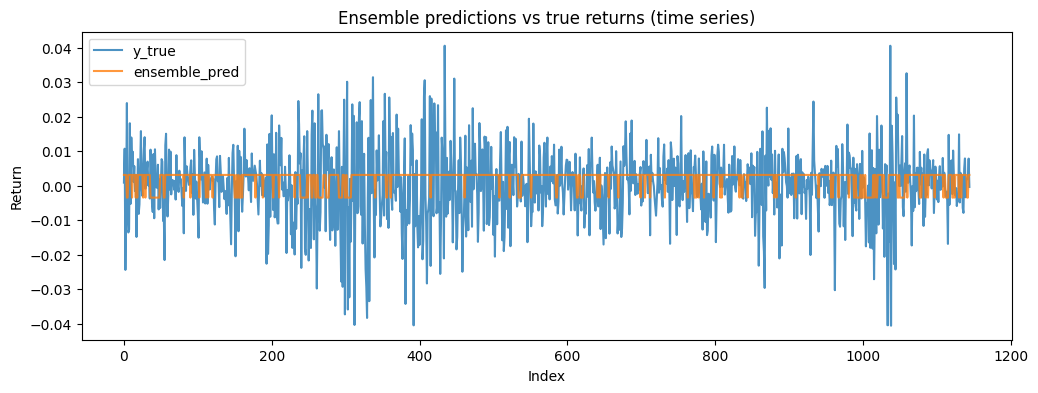

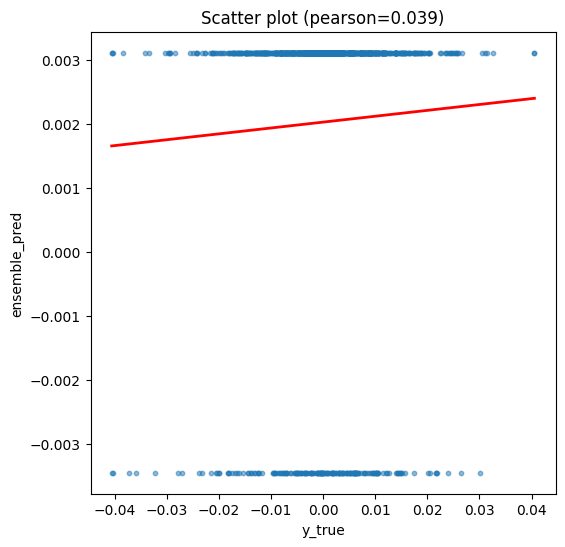

Pearson correlation: 0.03933344927989576
Hit rate: 0.514410480349345


In [66]:
# plot ensemble_eval vs y_eval (time series + scatter)
e = np.asarray(logistic_predict_eval).flatten()
y = np.asarray(y_eval).flatten()

n = min(len(e), len(y))
e = e[:n]
y = y[:n]

# try to keep original index if available
idx = getattr(y_eval, "index", None)
if idx is None or len(idx) < n:
    idx = range(n)
else:
    idx = idx[:n]

s_ens = pd.Series(e, index=idx, name="ensemble_pred")
s_y = pd.Series(y, index=idx, name="y_true")

plt.figure(figsize=(12, 4))
plt.plot(s_y, label="y_true", alpha=0.8)
plt.plot(s_ens, label="ensemble_pred", alpha=0.8)
plt.legend()
plt.title("Ensemble predictions vs true returns (time series)")
plt.xlabel("Index")
plt.ylabel("Return")
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(s_y, s_ens, s=10, alpha=0.5)
m, b = np.polyfit(s_y, s_ens, 1)
xs = np.linspace(s_y.min(), s_y.max(), 100)
plt.plot(xs, m * xs + b, color="red", lw=2)
plt.xlabel("y_true")
plt.ylabel("ensemble_pred")
plt.title(f"Scatter plot (pearson={pearson_corr(s_y, s_ens):.3f})")
plt.show()

print("Pearson correlation:", pearson_corr(s_y, s_ens))
print("Hit rate:", hit_rate(s_y, s_ens))

In [46]:
def ewma_step(prev_var: float, prev_ret: float, lam: float = 0.94) -> float:
    """Given yesterday's variance v_t and return r_t (same units you trained on),
    return v_{t+1} = λ v_t + (1-λ) r_t^2."""
    #print(lam, prev_var, prev_ret)
    return lam * float(prev_var) + (1.0 - lam) * (float(prev_ret) ** 2)

In [47]:
X_train

,D1_rollmean5,D2_rollmean5,D3_rollmean5,D4_rollmean5,D5_rollmean5,D6_rollmean5,D7_rollmean5,D8_rollmean5,D9_rollmean5,E1_rollmean5,...,V13_z60,V2_z60,V3_z60,V4_z60,V5_z60,V6_z60,V7_z60,V8_z60,lagged_market_forward_excess_returns_z60,lagged_risk_free_rate_z60
0,0.0,0.0,0.2,1.0,0.0,0.0,0.0,0.0,0.0,2.185767,...,-1.411939,-0.972556,-0.298533,-0.199988,-0.457654,0.000000,-1.160732,0.000000,-0.350950,0.970820
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.181245,...,-1.174449,0.717809,0.591987,0.310173,0.601800,0.000000,-1.162705,0.000000,0.465635,0.815838
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.176746,...,-0.106902,0.245912,0.971052,0.059298,0.583099,0.000000,0.065339,0.000000,-0.549076,0.789853
3,0.0,0.0,0.0,1.0,0.0,-0.2,0.0,0.0,0.0,2.172271,...,-0.515806,0.089773,-1.109595,-0.871174,1.383436,0.000000,-0.538323,0.000000,1.996067,0.888372
4,0.0,0.0,0.0,1.0,0.0,-0.4,0.0,0.0,0.0,2.167817,...,0.279067,-0.521803,-0.566009,-0.867286,2.693936,0.000000,0.405928,0.000000,0.058054,1.478562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,0.0,1.0,0.8,0.0,0.0,0.6,0.4,1.199291,...,-0.841192,3.667976,3.149142,3.762696,1.649973,1.359539,-0.691548,-0.605762,1.041404,0.648197
3996,0.0,0.0,0.0,1.0,0.8,0.0,0.0,0.4,0.6,1.197671,...,-0.761871,3.234680,1.784685,3.933179,1.102063,1.205776,-0.641907,-0.604069,-0.031339,0.653670
3997,0.0,0.0,0.0,1.0,0.6,0.0,0.0,0.2,0.6,1.196053,...,-0.882606,2.806853,0.530595,3.442636,0.606487,1.129071,-0.832070,-0.584548,0.031957,0.967837
3998,0.0,0.0,0.0,1.0,0.4,0.0,0.2,0.0,0.6,1.194439,...,-1.018715,2.428923,1.253472,3.242438,0.717589,1.021225,-1.019148,-0.577461,0.380232,0.876992


In [48]:
X_test_and_hist = pd.read_csv('X_test_raw.csv')
y_test = pd.read_csv('y_test.csv')

In [49]:
X_test_and_hist

,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,...,V2,V3,V4,V5,V6,V7,V8,V9,lagged_market_forward_excess_returns,lagged_risk_free_rate
0,0,0,0,1,0,0,0,0,0,1.448798,...,0.360450,0.150794,0.454365,-0.002722,0.527778,0.619058,0.458333,0.884527,0.012172,0.000003
1,0,0,0,1,0,0,0,0,0,1.446609,...,0.334656,0.143519,0.424603,0.024646,0.575397,0.649796,0.469577,0.887704,-0.005689,0.000003
2,0,0,0,1,0,-1,0,0,0,1.444427,...,0.312831,0.088624,0.406746,-0.052851,0.594577,0.785920,0.448743,1.028845,-0.012345,0.000003
3,0,0,0,1,0,-1,0,0,0,1.442250,...,0.298942,0.346561,0.277116,0.504252,0.331349,0.696597,0.475198,0.944530,0.003900,0.000003
4,0,0,0,1,0,-1,0,0,0,1.440078,...,0.273148,0.251323,0.210979,0.499339,0.606481,0.767239,0.477183,0.979982,-0.007158,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,0,0,0,0,0,0,0,0,0,1.565379,...,0.785053,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,-0.649616,-0.003365,0.000159
1206,0,0,0,0,0,0,0,0,0,1.562946,...,0.767857,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,-0.668289,0.001990,0.000155
1207,0,0,1,0,0,0,0,0,0,1.560520,...,0.734127,0.481481,0.787698,0.834898,0.823413,-0.723949,0.133929,-0.670946,0.001845,0.000156
1208,0,0,0,0,0,0,0,0,0,1.558102,...,0.695106,0.655423,0.783730,0.994026,0.851852,-0.684937,0.101852,-0.646265,0.002424,0.000156


In [50]:
y_eval

0       0.000906
1       0.010711
2      -0.024404
3      -0.005461
4       0.023931
          ...   
1140    0.001990
1141    0.001845
1142    0.002424
1143    0.007843
1144   -0.000368
Name: market_forward_excess_returns, Length: 1145, dtype: float64

In [51]:
y_test

,forward_returns,risk_free_rate,market_forward_excess_returns
0,0.001214,9.920635e-07,0.000906
1,0.011019,9.126984e-07,0.010711
2,-0.024096,1.111111e-06,-0.024404
3,-0.005153,1.309524e-06,-0.005461
4,0.024240,1.388889e-06,0.023931
...,...,...,...
1140,0.002457,1.551587e-04,0.001990
1141,0.002312,1.558730e-04,0.001845
1142,0.002891,1.564683e-04,0.002424
1143,0.008310,1.559524e-04,0.007843


In [52]:
def predict(test: pd.DataFrame, smoothing = False) -> float:
    X_test = test.copy()
    global X_hist
    global rf
    global rf_calibrate_model
    global logistic
    global logistic_calibrate_model
    global lightgbm
    global lightgbm_calibrate_model
    global regression_features
    global tree_features
    global btree_features
    #global prev_var
    X_hist = pd.concat([X_hist,X_test], ignore_index = True)
    #print(prev_var, prev_ret)

    #X_enriched_hist = make_rolling_features(make_lag_features(X_hist, X_hist.columns, lags = (1, 2, 3, 4, 5, 10, 20)), X_hist.columns, windows = (5, 10, 20), stats = ['mean', 'std', 'min', 'max'], zscore=True)
    X_enriched_hist = make_rolling_features(X_hist, X_hist.columns, windows = (5, 20, 60), stats = ['mean', 'std'], zscore = True)
    #print(X_enriched_hist)
    X_enriched_hist_cleaned = X_enriched_hist.ffill().fillna(0)
    X_enriched_test = X_enriched_hist_cleaned.iloc[-1:]
    logistic_mean = mean_predict(logistic, X_enriched_test[regression_features], logistic_calibrate_model)
    lightgbm_mean = mean_predict(lightgbm, X_enriched_test[sorted(btree_features)], lightgbm_calibrate_model)
    rf_mean = mean_predict(rf, X_enriched_test[sorted(tree_features)], rf_calibrate_model)
    ensemble_mean = (0.5*logistic_mean + 0.2*lightgbm_mean + 0.3*rf_mean)[0]
    predict_return = ensemble_mean
    if smoothing:
        global raw_predictions_history
        raw_predictions_history.append(ensemble_mean)
        predict_return = np.mean(raw_predictions_history)
    #ewma_var = ewma_step(prev_var, X_test['lagged_market_forward_excess_returns']) 
    # garch_var = garch_step(prev_var, prev_ret, alpha, beta, omega)
    # tree_var = tree_step(tree_model, X_enriched_test[tree_var_features])
    #print(ewma_var, garch_var, tree_var)
    #ensemble_var = (1*ewma_var)
    #prev_var = ensemble_var

    #print(ensemble_mean, ensemble_var)
    w = min(max(0, predict_return*800), 2)
    print(ensemble_mean, predict_return, w)
    return float(w), predict_return, ensemble_mean, logistic_mean, lightgbm_mean, rf_mean

In [54]:
prev_var = 1e-4
X_hist = X_test_and_hist[:65]
X_test = X_test_and_hist[65:]
positions = []
smoothed_returns = []
predicted_returns = []
logistic_mean_list = []
lightgbm_mean_list = []
rf_mean_list = []
raw_predictions_history = deque(maxlen=5)
for i in range (len(y_test)):
    w, smoothed_return, pred_return, logistic_mean, lightgbm_mean, rf_mean = predict(X_test.iloc[i:i+1])
    positions.append(w)
    smoothed_returns.append(smoothed_return)
    predicted_returns.append(pred_return)
    logistic_mean_list.append(logistic_mean)
    lightgbm_mean_list.append(lightgbm_mean)
    rf_mean_list.append(rf_mean)


0.0009091115675229005 0.0009091115675229005 0.7272892540183205
0.0013279812696567446 0.0013279812696567446 1.0623850157253958
0.0012642976135825823 0.0012642976135825823 1.0114380908660658
0.001163819863971982 0.001163819863971982 0.9310558911775856
-0.0013587958361195498 -0.0013587958361195498 0
-0.0013307009237978208 -0.0013307009237978208 0
0.0011606617059491595 0.0011606617059491595 0.9285293647593276
0.0014833459767325122 0.0014833459767325122 1.1866767813860097
0.0018215357807636412 0.0018215357807636412 1.457228624610913
0.0015695938126617046 0.0015695938126617046 1.2556750501293636
0.0013298176677199519 0.0013298176677199519 1.0638541341759615
-0.0016347724110764895 -0.0016347724110764895 0
0.0014394475213377177 0.0014394475213377177 1.1515580170701742
0.0012170111830859338 0.0012170111830859338 0.9736089464687471
0.0011929197098524485 0.0011929197098524485 0.9543357678819588
0.0012146734759581872 0.0012146734759581872 0.9717387807665498
-0.001994166842789386 -0.001994166842789

In [55]:
def score(solution: pd.DataFrame, submission) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """

  
    solution = solution.copy()
    solution.loc[:, 'position'] = submission

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()
    trading_days_per_yr = 252
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()


    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100
    print(strategy_mean_excess_return, market_mean_excess_return, strategy_volatility, market_volatility)
    print(return_penalty, vol_penalty)
    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

In [56]:
score(y_test, [2.0]*len(y_test))

0.0006073861662541091 0.0003585083862873706 33.14806702843338 16.575634642900443
1.0 1.7998068093658859


0.25655550511971426

In [57]:
score(y_test, positions)

0.0007892007343608398 0.0003585083862873706 19.458389841148037 16.575634642900443
1.0 1


1.0220711306665746

In [58]:
hit_rate(y_test['market_forward_excess_returns'], [1.0]*len(y_test))

0.5170305676855895

In [59]:
hit_rate(y_test['market_forward_excess_returns'], positions)

0.5262032085561498

In [60]:
pearson_corr(y_test['market_forward_excess_returns'], predicted_returns)


0.0833824623435554

In [61]:
ensemble_eval

array([ 0.00090911,  0.00132798,  0.0012643 , ..., -0.00284798,
        0.00024713,  0.0002013 ])

In [62]:
predicted_returns

[np.float64(0.0009091115675229005),
 np.float64(0.0013279812696567446),
 np.float64(0.0012642976135825823),
 np.float64(0.001163819863971982),
 np.float64(-0.0013587958361195498),
 np.float64(-0.0013307009237978208),
 np.float64(0.0011606617059491595),
 np.float64(0.0014833459767325122),
 np.float64(0.0018215357807636412),
 np.float64(0.0015695938126617046),
 np.float64(0.0013298176677199519),
 np.float64(-0.0016347724110764895),
 np.float64(0.0014394475213377177),
 np.float64(0.0012170111830859338),
 np.float64(0.0011929197098524485),
 np.float64(0.0012146734759581872),
 np.float64(-0.001994166842789386),
 np.float64(0.0012912532746855731),
 np.float64(-0.002140759519473403),
 np.float64(0.0013296108431399207),
 np.float64(0.0014908165559649625),
 np.float64(0.0015271378357621913),
 np.float64(0.001961540906922006),
 np.float64(0.0025548398206858983),
 np.float64(0.0022002849421540807),
 np.float64(0.0020579891340755906),
 np.float64(-0.0012783234555741553),
 np.float64(0.002181644284

In [63]:
def hit_rate(y_true, y_pred, *, dropna: bool = True, margin: float = 0.0, count_ties: bool = False) -> float:
    """
    Sign accuracy (hit rate): fraction of times sign(y_pred) == sign(y_true).

    Parameters
    ----------
    y_true, y_pred : array-like
        Equal-length sequences of numbers.
    dropna : bool, default True
        If True, drop any pair with NaN in either array.
        If False and NaNs are present, returns np.nan.
    margin : float, default 0.0
        Treat predictions with |y_pred| <= margin as 0 (neutral band).
    count_ties : bool, default False
        If False, exclude any pair where sign is 0 on either side.
        If True, include pairs with sign==0 and count them as correct
        only when both are 0.

    Returns
    -------
    hit : float
        Proportion in [0,1], or np.nan if no eligible pairs.
    """
    a = np.asarray(y_true, dtype=float).flatten()
    b = np.asarray(y_pred, dtype=float).flatten()

    if a.shape != b.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    mask = np.isfinite(a) & np.isfinite(b)
    if not dropna and not mask.all():
        return np.nan
    a = a[mask]
    b = b[mask]

    # Apply neutral band to predictions
    if margin > 0:
        b = b.copy()
        b[np.abs(b) <= margin] = 0.0

    s_true = np.sign(a)
    s_pred = np.sign(b)

    if count_ties:
        eligible = np.ones_like(s_true, dtype=bool)
    else:
        eligible = (s_true != 0) & (s_pred != 0)

    if not np.any(eligible):
        return np.nan

    hits = (s_true[eligible] == s_pred[eligible]).mean()
    return float(hits)

In [64]:
def pearson_corr(y_true, y_pred):
    """
    Pearson correlation coefficient between y_true and y_pred.

    Parameters
    ----------
    y_true, y_pred : array-like
        Equal-length sequences of numbers.

    Returns
    -------
    corr : float
        Pearson correlation coefficient in [-1,1], or np.nan if undefined.
    """
    a = np.asarray(y_true, dtype=float).flatten()
    b = np.asarray(y_pred, dtype=float).flatten()

    if a.shape != b.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    mask = np.isfinite(a) & np.isfinite(b)
    a = a[mask]
    b = b[mask]

    if len(a) == 0:
        return np.nan

    corr, _ = pearsonr(a, b)
    return float(corr)